# Switching multi-armed bandit

The switching bandits are a variant of dynamic multi-armed bandits in which reward probability $p_{t, l}$ changes suddenly but is otherwise constant. Starting with the stationary model described in stationary_bandits_comparison.ipynb we will introduce reward probability changes as sudden switches in the arm associated with highest reward probability. 

At each time step the arm associated with the highest reward probability would either stay unchanged with probability $1-\rho$ or associated with another randomly selected arm with with probability $\rho$.

Here, we set the highest reward probability to $p_{max} = \epsilon + \frac{1}{2}$ and all other arms will be associated with $p=\frac{1}{2}$. This way three parameters define difficulty of inferring the best arm, $\epsilon$ the expected reward bonus, $\rho$ the transition probability, and $K$ the number of arms.

In [1]:
# append the path to the code folder
import sys
sys.path.append('../../')

# remove preallocation of gpu memory 
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

# load packages
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, lax, jit, vmap
from collections import defaultdict
from jupyterthemes import jtplot
from tqdm.notebook import tqdm
from multiprocessing import get_context
from scipy.stats import t

# set plotting environment
sns.set(style="ticks", palette='colorblind', color_codes=True, font_scale=1.6)
plt.rcParams.update({
    'axes.spines.right': False, 
    'axes.spines.top': False, 
    'lines.linewidth': 2., 
    'axes.xmargin': 0.01, 
    'savefig.dpi': 300,
})


In [2]:
# load or simulate the data for switching mabs with fixed difficulty
from run_switching_fixed_diff_sims import Sim

N = 1000
T = 5000
missing = []
regret_all = {}
for E in [5, 10, 20]:
    try:
        tmp = np.load('../../data/switching_e{}_T{}.npz'.format(E, T), allow_pickle=True)
        regret_all[E] = defaultdict(lambda: {})
        for name in tmp:
            regret_all[E][name] = tmp[name].item()
    except:
        missing.append(E)

if len(missing) > 0:
    # if files do not exist run simulations    
    rng_key = random.PRNGKey(12345678)
    job = Sim(N, T)
    for E in missing:
        eps = E/100
        regret_all[E] = defaultdict(lambda: {})
        for name in ['O-TS', 'B-UCB', 'G-AI', 'A-AI', 'S-AI']:
            nargs = []
            for rho in [.01, .02, .04]:
                R = int(100 * rho)
                regret_all[E][name][R] = []
                for K in [10, 20, 40, 80]:
                    rng_key, _rng_key = random.split(rng_key)
                    res, name, params = job(name, rho, eps, K, _rng_key[0])
                    regret_all[E][name][R].append( (K, np.array(res).astype(np.float32)) )
        
        np.savez('data/switching_e{}_T{}'.format(E, T), **regret_all[E])

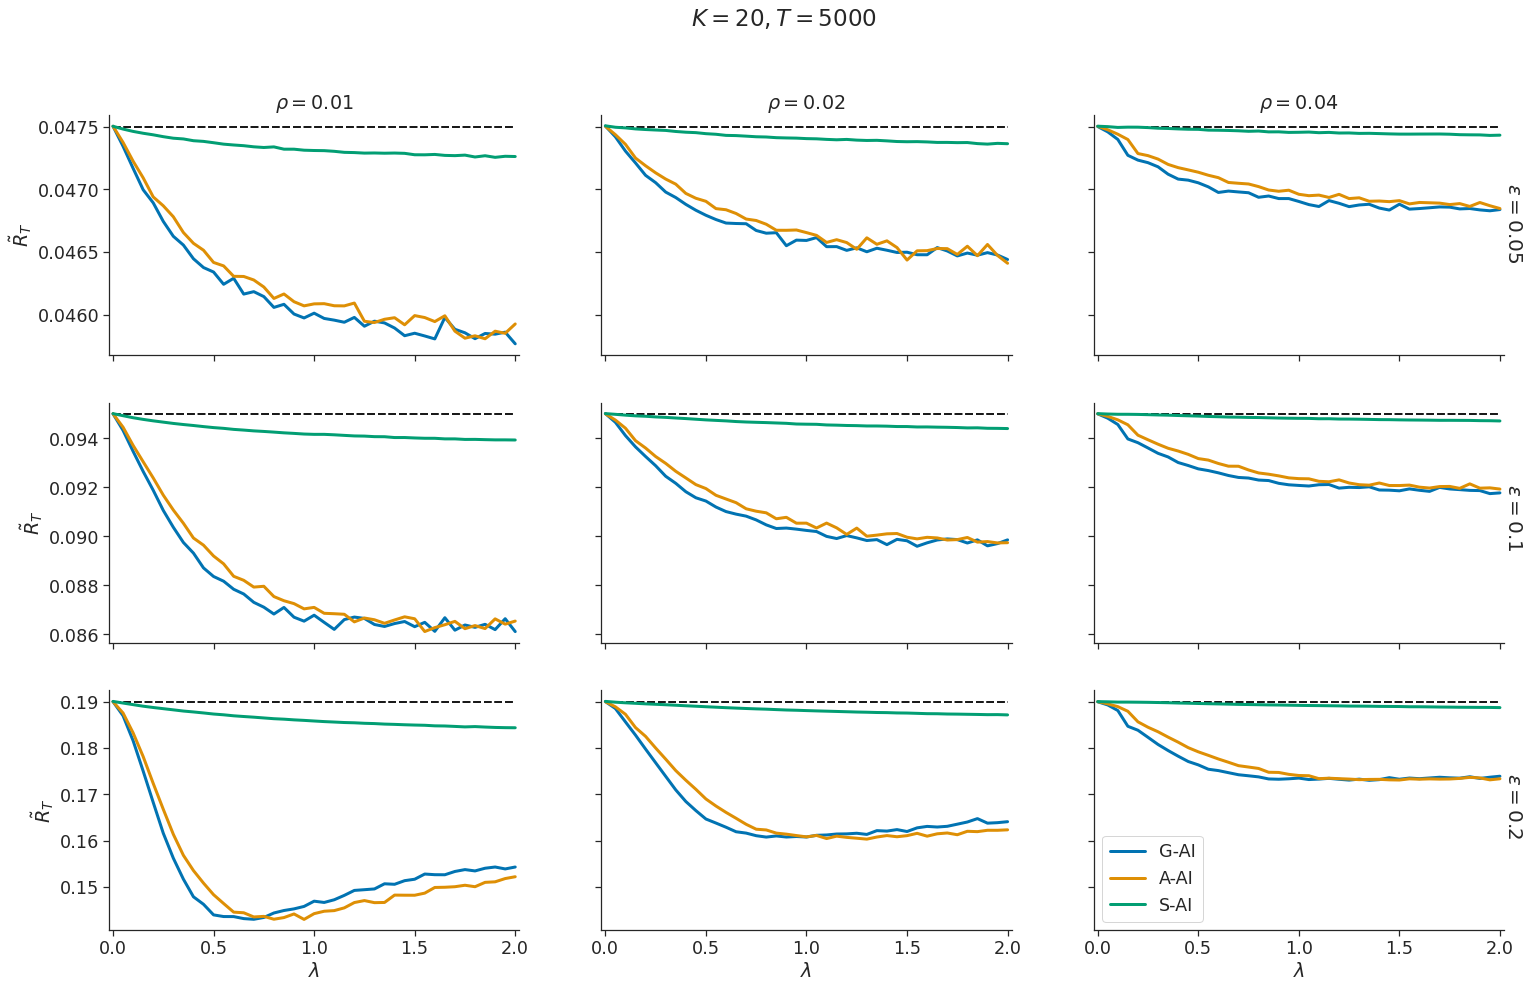

In [3]:
# plot dependence of regret rate on lambda in different difficulty levels

K_plot = 20
fig, axes = plt.subplots(3, 3, figsize=(25, 15), sharex=True, sharey='row')
colors = ['b', 'r']
linestyle = ['-', '--', '-.']
lambdas = jnp.arange(0, 2.05, .05)
for e, E in enumerate([5, 10, 20]):
    for name in regret_all[E]:
        if name in ['G-AI', 'A-AI', 'S-AI']:
            for r, R in enumerate([1, 2, 4]):
                for K, cum_reg in regret_all[E][name][R]:
                    if K == K_plot:
                        axes[e, r].plot(lambdas, cum_reg.mean(-1)[:, -2]/T, lw=3, label=name)
                        axes[e, r].hlines(E/100 * (K - 1)/K, lambdas[0], lambdas[-1], 'k', linestyle='--', lw=2)
                    
                if e == 2:
                    axes[e, r].set_xlabel(r'$\lambda$')
                if e == 0:
                    axes[e, r].set_title(r'$\rho={}$'.format(R/100))
    axes[e, 0].set_ylabel(r'$\tilde{R}_T$')
    axes[e, -1].text(1., .4, r'$\epsilon={}$'.format(E/100), transform=axes[e, -1].transAxes, fontsize=20, rotation=-90)

axes[-1, -1].legend(loc=0);
fig.suptitle(r'$K={}, T={}$'.format(K_plot, T));


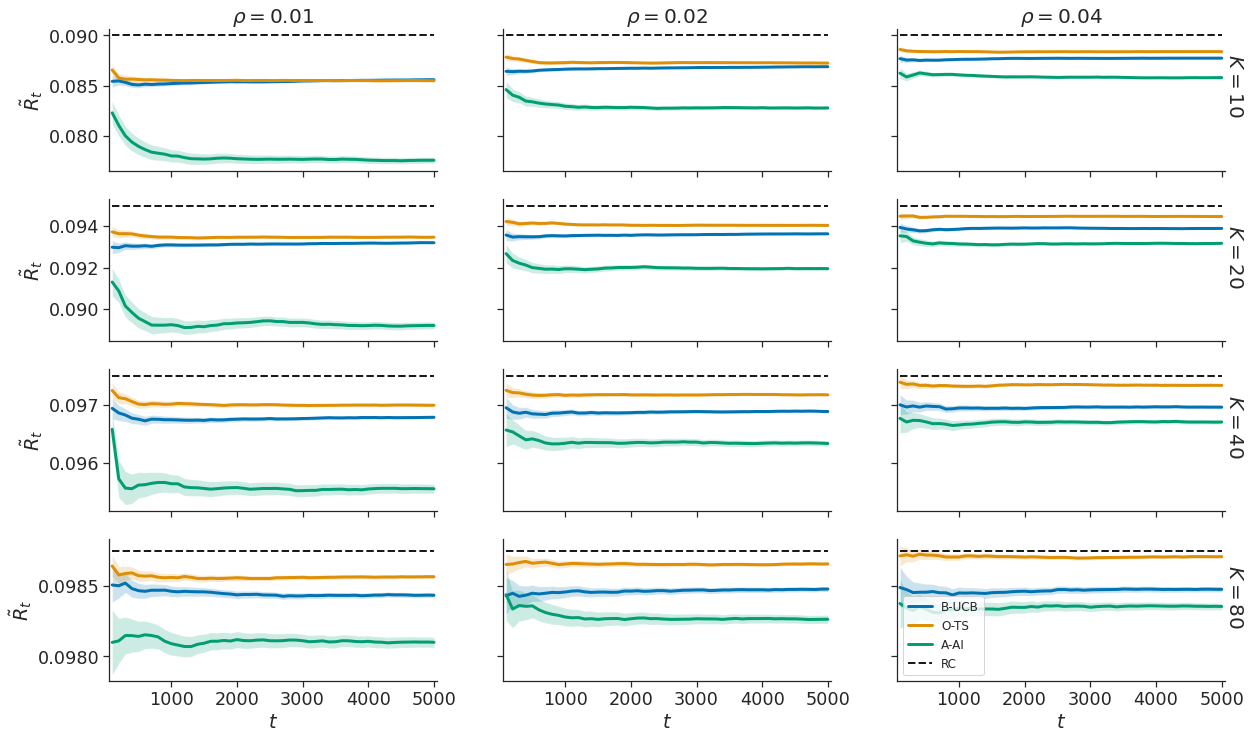

In [4]:
# plot regret rate for varying number of arms and switch probability
from scipy.stats import t

E = 10
eps = E/100
trials = jnp.arange(100, T+100, 100)
fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey='row')
labels = ['B-UCB', 'O-TS', 'A-AI']
lam = .5
loc_lam = np.argmax(lam < lambdas).item() - 1

t_bounds = t.interval(0.95, N - 1)

for i, K in enumerate([10, 20, 40, 80]):
    for j, R in enumerate([1, 2, 4]):
        for name in labels:
            for k, cum_reg in regret_all[E][name][R]:
                if k == K:
                    if name == 'A-AI':
                        mean = (cum_reg[loc_lam, :-1]/trials[:, None]).mean(-1)
                        std =  jnp.std((cum_reg[loc_lam, :-1]/trials[:, None]), axis=-1, ddof=1)
                        ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]
                    else:
                        mean = (cum_reg[:-1]/trials[:, None]).mean(-1)
                        std =  jnp.std((cum_reg[:-1]/trials[:, None]), axis=-1, ddof=1)
                        ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]

                    axes[i, j].plot(trials, mean, lw=3, label=name)
                    axes[i, j].fill_between(trials, ci[1], y2=ci[0], alpha=.2)
        
        axes[i, j].hlines(eps * (K - 1)/K, trials[0], trials[-1], color='k', linestyle='--', label='RC')
    
        if i == 3:
            axes[i, j].set_xlabel(r'$t$')
        if i == 0:
            axes[i, j].set_title(r'$\rho={}$'.format(R/100.), fontsize=20)

    axes[i, -1].text(1., .4, r'$K={}$'.format(K), transform=axes[i, -1].transAxes, fontsize=20, rotation=-90)
    axes[i, 0].set_ylabel(r'$\tilde{R}_t$')

plt.legend(loc=0, fontsize=12);
fig.savefig('Fig3.pdf', transparent=True, bbox_inches='tight', dpi=300)

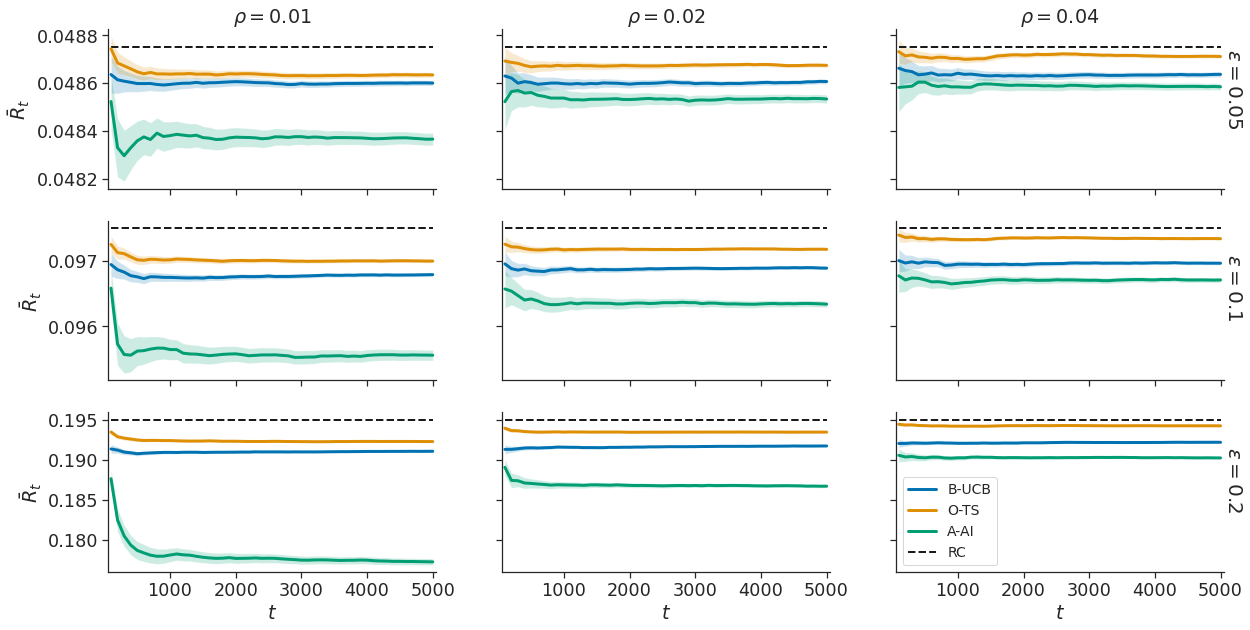

In [5]:
# plot for varying epsilon levels nad switch probability
K_plot = 40
trials = jnp.arange(100, T+100, 100)
fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='row')
labels = ['B-UCB', 'O-TS', 'A-AI']
lam = .5
loc_lam = np.argmax(lam < lambdas).item() - 1

t_bounds = t.interval(0.95, N - 1)
for i, E in enumerate([5, 10, 20]):
    for j, R in enumerate([1, 2, 4]):
        for name in labels:
            for k, cum_reg in regret_all[E][name][R]:
                if k == K_plot:
                    if name == 'A-AI':
                        mean = (cum_reg[loc_lam, :-1]/trials[:, None]).mean(-1)
                        std =  jnp.std((cum_reg[loc_lam, :-1]/trials[:, None]), axis=-1, ddof=1)
                        ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]
                    else:
                        mean = (cum_reg[:-1]/trials[:, None]).mean(-1)
                        std =  jnp.std((cum_reg[:-1]/trials[:, None]), axis=-1, ddof=1)
                        ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]

                    axes[i, j].plot(trials, mean, lw=3, label=name)
                    axes[i, j].fill_between(trials, ci[1], y2=ci[0], alpha=.2)
        axes[i, j].hlines(E/100 * (K_plot - 1)/K_plot, trials[0], trials[-1], color='k', linestyle='--', label='RC')
        if i == 0:
            axes[i, j].set_title(r'$\rho={}$'.format(R/100))
        if i == 2:
            axes[i, j].set_xlabel(r'$t$')
    
    axes[i, -1].text(1., .4, r'$\epsilon={}$'.format(E/100), transform=axes[i, -1].transAxes, fontsize=20, rotation=-90)
    axes[i, 0].set_ylabel(r'$\bar{R}_t$')

axes[-1, -1].legend(fontsize=14);
fig.savefig('Fig4.pdf', transparent=True, bbox_inches='tight', dpi=300)

In [6]:
# load or simulate the data for switching mabs with varying difficulty (varying epsilon)
from run_switching_varying_diff_sims import Sim

N = 1000
T = 5000
missing = False
try:
    tmp = np.load('../../data/switching_varying_T{}.npz'.format(T), allow_pickle=True)
    regret_all2 = defaultdict(lambda: {})
    for name in tmp:
        regret_all2[name] = tmp[name].item()
        for R in regret_all2[name]:
            dct = {}
            for K, cum_reg in regret_all2[name][R]:
                dct[K] = cum_reg
            regret_all2[name][R] = dct
except:
    missing = True

if missing > 0:
    # if files do not exist run simulations    
    rng_key = random.PRNGKey(12345678)
    job = Simulator(N, T)
    regret_all2 = defaultdict(lambda: {})
    for name in ['O-TS', 'B-UCB', 'G-AI', 'A-AI', 'S-AI']:
        nargs = []
        for rho in [.01, .02, .04]:
            R = int(100 * rho)
            regret_all[name][R] = []
            for K in [10, 20, 40, 80]:
                rng_key, _rng_key = random.split(rng_key)
                res, name, params = job(name, rho, K, _rng_key[0])
                regret_all[E][name][R].append( (K, np.array(res).astype(np.float32)) )
    
    np.savez('data/switching_varying_T{}'.format(E, T), **regret_all[E])

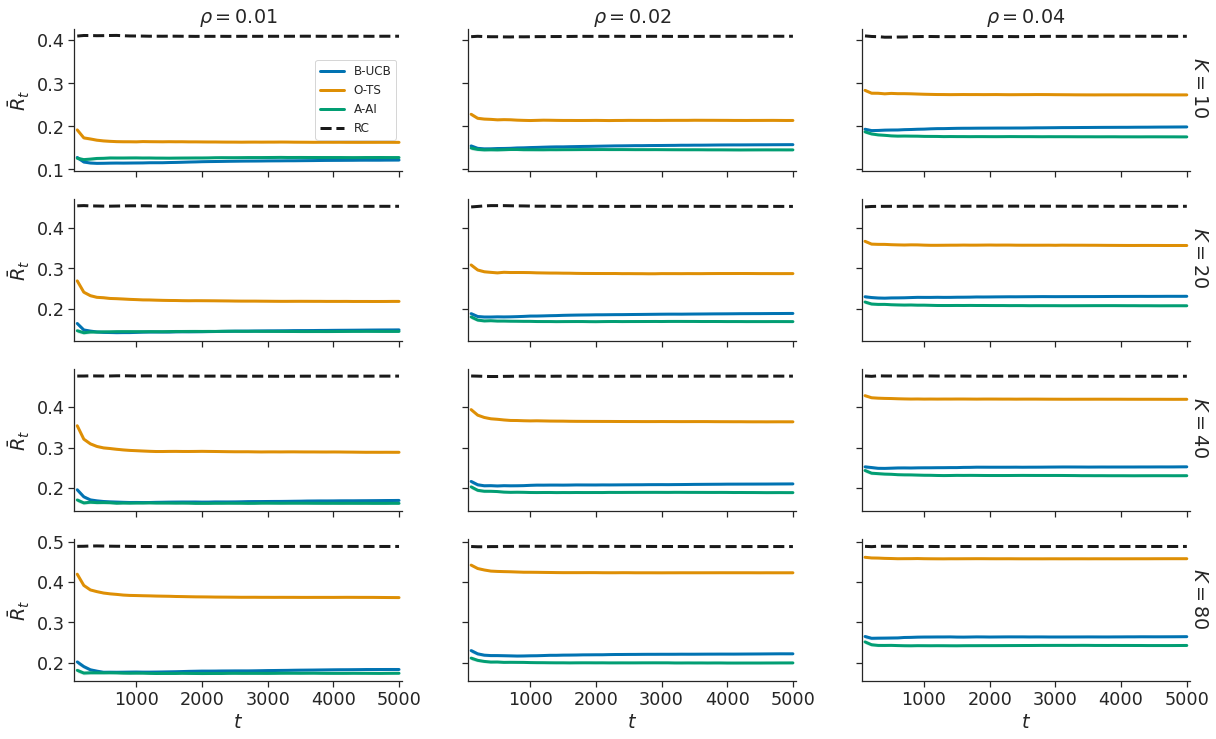

In [49]:
# plot regret rate for varying difficulty
trials = jnp.arange(100, T+100, 100)
fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey='row')
labels = ['B-UCB', 'O-TS', 'A-AI']

lambdas = np.arange(0, 2.05, .05)
lam = .5
loc_lam = np.argmax(lam < lambdas).item() - 1

t_bounds = t.interval(0.95, N - 1)

for i, K in enumerate([10, 20, 40, 80]):
    for j, R in enumerate([1, 2, 4]):
        for name in labels:
            if name == 'A-AI':
                cum_reg = regret_all2[name][R][K][loc_lam]
            else:
                cum_reg = regret_all2[name][R][K]
            mean = jnp.mean(cum_reg/trials[:, None], -1)
            std = jnp.std(cum_reg/trials[:, None], -1, ddof=1)
            ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]
            axes[i, j].plot(trials, mean, lw=3, label=name)
            axes[i, j].fill_between(trials, ci[1], y2=ci[0], alpha=.2)

        # plot random choices
        mean = jnp.mean(regret_all2['RC'][R][K]/trials[:, None], -1)
        axes[i, j].plot(trials, mean, 'k--', lw=3, label='RC')

        if i == 3:
            axes[i, j].set_xlabel(r'$t$')
        if i == 0:
            axes[i, j].set_title(r'$\rho={}$'.format(R/100))
    axes[i, -1].text(1., .4, r'$K={}$'.format(K), transform=axes[i, -1].transAxes, rotation=-90)
    axes[i, 0].set_ylabel(r'$\bar{R}_t$')

axes[0,0].legend(fontsize=12);
fig.savefig('Fig5.pdf', transparent=True, bbox_inches='tight', dpi=300)

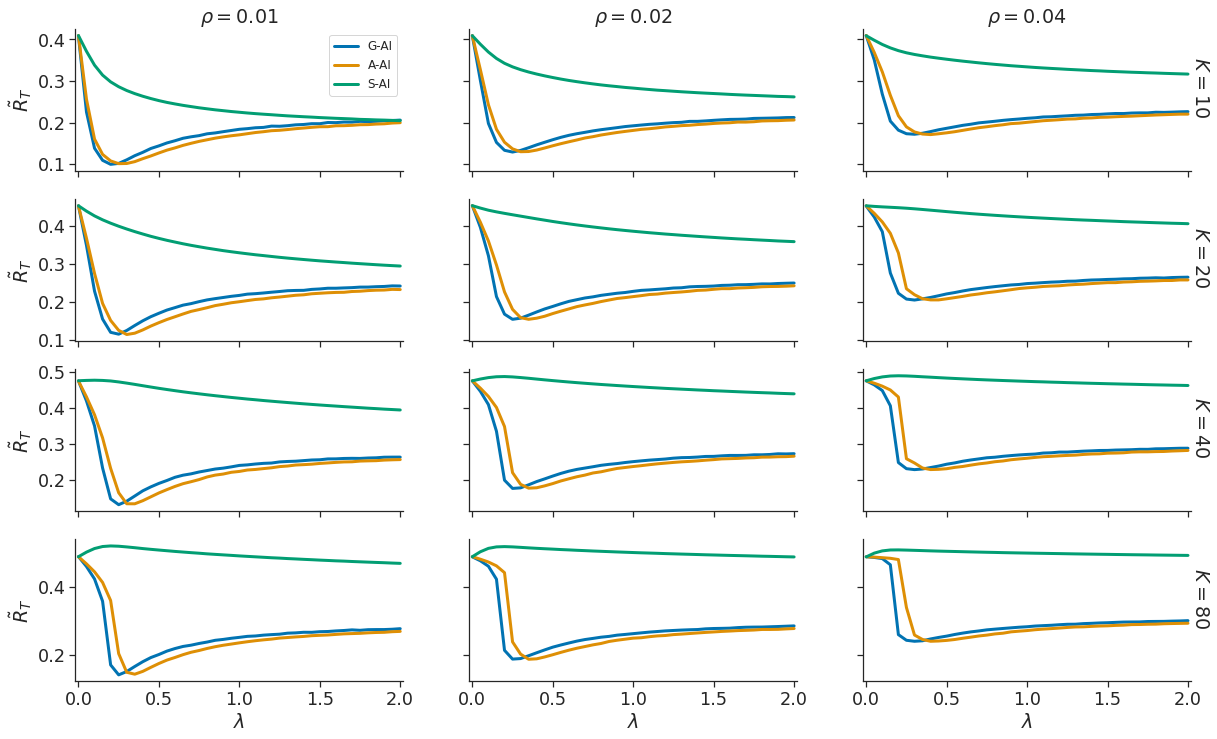

In [43]:
# plot regret rate as a function of lambda in the case of varying difficulty
fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey='row')
lambdas = jnp.arange(0, 2.05, .05)

for i, K in enumerate([10, 20, 40, 80]):
    for r, R in enumerate([1, 2, 4]):
        for name in ['G-AI', 'A-AI', 'S-AI']:
            cum_reg = regret_all2[name][R][K]
            axes[i, r].plot(lambdas, np.mean(cum_reg, -1)[:, -1]/T, lw=3, label=name)
            
        if i == 3:
            axes[i, r].set_xlabel(r'$\lambda$')
        if i == 0:
            axes[i, r].set_title(r'$\rho={}$'.format(R/100))
    axes[i, 0].set_ylabel(r'$\tilde{R}_T$')
    axes[i, -1].text(1., .4, r'$K={}$'.format(K), transform=axes[i, -1].transAxes, rotation=-90)

axes[0, 0].legend(loc=0, fontsize=12);